In [90]:
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = (35,7)

import numpy as np

In [3]:
def read_data(filename, cols_to_read, rows_to_read):
    
    if cols_to_read is None:
        df = pd.read_csv(filename).fillna(method='ffill')
    else:
        df = pd.read_csv(filename, usecols=cols_to_read).fillna(method='ffill')
    
    df = df.iloc[rows_to_read].astype({
        'IP.NSRCGEN:BIASDISCAQNV' : 'float32',
        'IP.NSRCGEN:GASSASAQN' : 'float32',
        'IP.NSRCGEN:OVEN1AQNP' : 'float32',
        'IP.NSRCGEN:SOURCEHTAQNI' : 'float32',
        'IP.SAIREM2:FORWARDPOWER' : 'float32',
        'IP.SOLCEN.ACQUISITION:CURRENT' : 'float32',
        'IP.SOLEXT.ACQUISITION:CURRENT' : 'float32',
        'IP.SOLINJ.ACQUISITION:CURRENT' : 'float32',
        'ITF.BCT15:CURRENT' : 'float32',
        'ITF.BCT25:CURRENT' : 'float32',
        'ITH.BCT41:CURRENT' : 'float32',
        'ITL.BCT05:CURRENT' : 'float32',
    })
    return df

In [4]:
def clean_data(data):
    data.dropna(inplace=True)
    data.drop(data[data['ITF.BCT15:CURRENT'] < 0].index, inplace=True)
    data.drop(data[data['ITF.BCT25:CURRENT'] < 0].index, inplace=True)
    data.drop(data[data['ITH.BCT41:CURRENT'] < 0].index, inplace=True)
    data.drop(data[data['ITL.BCT05:CURRENT'] < 0].index, inplace=True)
    data.drop(data[data['IP.NSRCGEN:OVEN1AQNP'] < 4.5].index, inplace=True)
    data.drop(data[data['IP.SOLEXT.ACQUISITION:CURRENT'] < 1200].index, inplace=True)
    data.drop(data[data['IP.NSRCGEN:BIASDISCAQNV'] == 0].index, inplace=True)
    data.drop(data[data['IP.SAIREM2:FORWARDPOWER'] < 500].index, inplace=True)
    data.drop(data[data['IP.NSRCGEN:SOURCEHTAQNI'] > 2.5].index, inplace=True)
    data.drop(data[data['IP.NSRCGEN:SOURCEHTAQNI'] < 0.5].index, inplace=True)

In [5]:
current_mean_min = 0.025
current_var_max = 0.0001
sliding_window_size = int(100*60/1.2)

def is_source_stable(mean, var):
    if mean == float('NaN') or var == float('NaN'):
        return ''
    return 1 if mean > current_mean_min and var < current_var_max else 0

In [6]:
data_raw_file = '../Data_Raw/Nov2018.csv'

In [67]:
cols_to_read = ['Timestamp (UTC_TIME)', 'IP.NSRCGEN:BIASDISCAQNV', 'IP.NSRCGEN:GASSASAQN', 'ITF.BCT25:CURRENT', 'IP.SOLCEN.ACQUISITION:CURRENT']
rows_to_read = list(range(500000, 1500000))
df = read_data(data_raw_file, None, rows_to_read)

In [68]:
clean_data(df)
df = df[cols_to_read].copy()

In [69]:
df['ITF.BCT25:CURRENT_MEAN'] = df['ITF.BCT25:CURRENT'].rolling(sliding_window_size).mean()
df['ITF.BCT25:CURRENT_VAR'] = df['ITF.BCT25:CURRENT'].rolling(sliding_window_size).var()

In [70]:
df['IS_STABLE'] = df.apply(lambda row: is_source_stable(row['ITF.BCT25:CURRENT_MEAN'], row['ITF.BCT25:CURRENT_VAR']), axis=1)

### Generating sample Data
For testing purposes we will use randomly generated data, where we know which clusters to expect.

In [189]:
mean1 = [0,0,0]
cov1 = [[10, 0, 0], [0, 10, 0], [0, 0, 0.1]]
x1, y1, z1 = np.random.multivariate_normal(mean1, cov1, 2500000).T
df = pd.DataFrame({'IP.NSRCGEN:BIASDISCAQNV':x1, 'IP.NSRCGEN:GASSASAQN':y1, 'IP.SOLCEN.ACQUISITION:CURRENT':z1})
df['IS_STABLE']=True

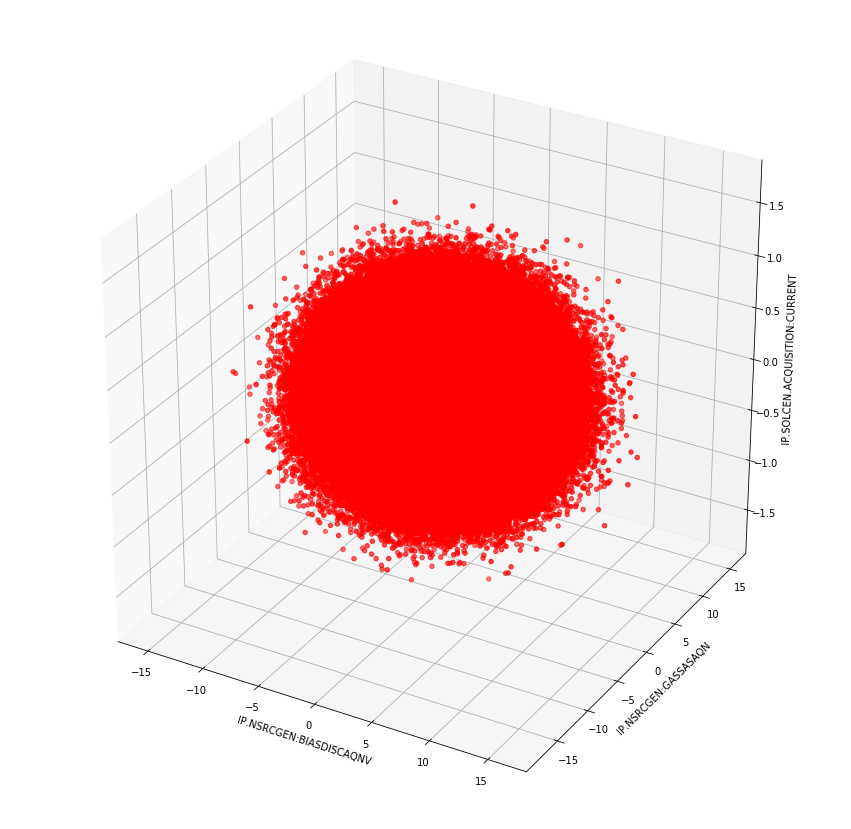

In [190]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (15,15)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['IP.NSRCGEN:BIASDISCAQNV'], df['IP.NSRCGEN:GASSASAQN'], df['IP.SOLCEN.ACQUISITION:CURRENT'], c='r', marker='o')
#ax.scatter(x1, y1, z1, c='r', marker='o')

ax.set_xlabel('IP.NSRCGEN:BIASDISCAQNV')
ax.set_ylabel('IP.NSRCGEN:GASSASAQN')
ax.set_zlabel('IP.SOLCEN.ACQUISITION:CURRENT')

plt.show()

### Histogram creation
We create a multidimensional histogram. Bin size should be revised by an expert.

**Definition (density):** The value of a bin is the amount of values contained in it, in percent. This shall be called density.

In [194]:
bins = [100, 100, 100] # [100, 35, 100]
cols_to_cluster = ['IP.NSRCGEN:BIASDISCAQNV', 'IP.NSRCGEN:GASSASAQN', 'IP.SOLCEN.ACQUISITION:CURRENT']
H, edges = np.histogramdd(df.loc[df['IS_STABLE']==True][cols_to_cluster].values, bins=bins, density=True)

normalization_factor = np.prod([abs(edges[i][1] - edges[i][0]) for i in range(len(bins))])
H = H * normalization_factor

edges

[array([-15.4461022 , -15.13190665, -14.81771111, -14.50351556,
        -14.18932002, -13.87512447, -13.56092893, -13.24673338,
        -12.93253784, -12.61834229, -12.30414675, -11.9899512 ,
        -11.67575566, -11.36156011, -11.04736457, -10.73316903,
        -10.41897348, -10.10477794,  -9.79058239,  -9.47638685,
         -9.1621913 ,  -8.84799576,  -8.53380021,  -8.21960467,
         -7.90540912,  -7.59121358,  -7.27701803,  -6.96282249,
         -6.64862694,  -6.3344314 ,  -6.02023585,  -5.70604031,
         -5.39184476,  -5.07764922,  -4.76345367,  -4.44925813,
         -4.13506258,  -3.82086704,  -3.5066715 ,  -3.19247595,
         -2.87828041,  -2.56408486,  -2.24988932,  -1.93569377,
         -1.62149823,  -1.30730268,  -0.99310714,  -0.67891159,
         -0.36471605,  -0.0505205 ,   0.26367504,   0.57787059,
          0.89206613,   1.20626168,   1.52045722,   1.83465277,
          2.14884831,   2.46304386,   2.7772394 ,   3.09143494,
          3.40563049,   3.71982603,   4.

In [195]:
perms = [(a, b, c) for a in range(bins[0]) for b in range(bins[1]) for c in range(bins[2])]

In [196]:
hist_mean = np.mean(H)
hist_std = np.std(H)
threshold = hist_mean
threshold

9.999999999999936e-07

### Nearest neighbor clustering
The created histogram now has to be clustered. Due to the nature of the data, we get a very sparse spacial distribution, therefore we can discard every cell below a certain threshold. We will chose the _mean plus one standandard deviation_ of the distributed density, but this has to be a subject for further experiments. The resulting object can be interprated as a graph where the connected components represent different clusters. Two nodes will be considered connected, if they are direct neigbours in at least one spacial dimension, i.e. every node (except for the boundary) has _2d_ neighbours, where _d_ is the dimension.

We use BFS to get the connected components in the graph.

In [197]:
clusters = np.ones(bins)
clusters *= -1

In [198]:
def do_BFS_step(p, clusters, current_cluster, bins, H, threshold):
    result = []
    if clusters[p] >= 0 or H[p] < threshold: # Node has to be ignored. Else assign to cluster and find children.
        return result
    
    clusters[p] = current_cluster
    for i in range(len(p)):
        if p[i] > 0:
            result.append(list(p))
            result[-1][i] -= 1
        if p[i] + 1 < bins[i]:
            result.append(list(p))
            result[-1][i] += 1
    return result

current_cluster = 0

for p in perms:
    if clusters[p] >= 0 or H[p] < threshold:
        continue
    
    print("Started search for cluster {}".format(current_cluster))
    nodes_to_check = do_BFS_step(p, clusters, current_cluster, bins, H, threshold)
    while len(nodes_to_check) > 0:
        node = nodes_to_check.pop(0)
        nodes_to_check.extend(do_BFS_step(tuple(node), clusters, current_cluster, bins, H, threshold))
    
    current_cluster += 1

print("Found {} cluster(s)".format(current_cluster))

Started search for cluster 0
Started search for cluster 1
Started search for cluster 2
Started search for cluster 3
Started search for cluster 4
Started search for cluster 5
Started search for cluster 6
Started search for cluster 7
Started search for cluster 8
Started search for cluster 9
Started search for cluster 10
Started search for cluster 11
Started search for cluster 12
Started search for cluster 13
Started search for cluster 14
Started search for cluster 15
Started search for cluster 16
Started search for cluster 17
Started search for cluster 18
Started search for cluster 19
Started search for cluster 20
Started search for cluster 21
Started search for cluster 22
Started search for cluster 23
Started search for cluster 24
Started search for cluster 25
Started search for cluster 26
Started search for cluster 27
Started search for cluster 28
Started search for cluster 29
Started search for cluster 30
Started search for cluster 31
Started search for cluster 32
Started search for c

Started search for cluster 816
Started search for cluster 817
Started search for cluster 818
Started search for cluster 819
Started search for cluster 820
Started search for cluster 821
Started search for cluster 822
Started search for cluster 823
Started search for cluster 824
Started search for cluster 825
Started search for cluster 826
Started search for cluster 827
Started search for cluster 828
Started search for cluster 829
Started search for cluster 830
Started search for cluster 831
Started search for cluster 832
Started search for cluster 833
Started search for cluster 834
Started search for cluster 835
Started search for cluster 836
Started search for cluster 837
Started search for cluster 838
Started search for cluster 839
Started search for cluster 840
Started search for cluster 841
Started search for cluster 842
Started search for cluster 843
Started search for cluster 844
Started search for cluster 845
Started search for cluster 846
Started search for cluster 847
Started 

Started search for cluster 1414
Started search for cluster 1415
Started search for cluster 1416
Started search for cluster 1417
Started search for cluster 1418
Started search for cluster 1419
Started search for cluster 1420
Started search for cluster 1421
Started search for cluster 1422
Started search for cluster 1423
Started search for cluster 1424
Started search for cluster 1425
Started search for cluster 1426
Started search for cluster 1427
Started search for cluster 1428
Started search for cluster 1429
Started search for cluster 1430
Started search for cluster 1431
Started search for cluster 1432
Started search for cluster 1433
Started search for cluster 1434
Started search for cluster 1435
Started search for cluster 1436
Started search for cluster 1437
Started search for cluster 1438
Started search for cluster 1439
Started search for cluster 1440
Started search for cluster 1441
Started search for cluster 1442
Started search for cluster 1443
Started search for cluster 1444
Started 

Started search for cluster 1992
Started search for cluster 1993
Started search for cluster 1994
Started search for cluster 1995
Started search for cluster 1996
Started search for cluster 1997
Started search for cluster 1998
Started search for cluster 1999
Started search for cluster 2000
Started search for cluster 2001
Started search for cluster 2002
Started search for cluster 2003
Started search for cluster 2004
Started search for cluster 2005
Started search for cluster 2006
Started search for cluster 2007
Started search for cluster 2008
Started search for cluster 2009
Started search for cluster 2010
Started search for cluster 2011
Started search for cluster 2012
Started search for cluster 2013
Started search for cluster 2014
Started search for cluster 2015
Started search for cluster 2016
Started search for cluster 2017
Started search for cluster 2018
Started search for cluster 2019
Started search for cluster 2020
Started search for cluster 2021
Started search for cluster 2022
Started 

Started search for cluster 2637
Started search for cluster 2638
Started search for cluster 2639
Started search for cluster 2640
Started search for cluster 2641
Started search for cluster 2642
Started search for cluster 2643
Started search for cluster 2644
Started search for cluster 2645
Started search for cluster 2646
Started search for cluster 2647
Started search for cluster 2648
Started search for cluster 2649
Started search for cluster 2650
Started search for cluster 2651
Started search for cluster 2652
Started search for cluster 2653
Started search for cluster 2654
Started search for cluster 2655
Started search for cluster 2656
Started search for cluster 2657
Started search for cluster 2658
Started search for cluster 2659
Started search for cluster 2660
Started search for cluster 2661
Started search for cluster 2662
Started search for cluster 2663
Started search for cluster 2664
Started search for cluster 2665
Started search for cluster 2666
Started search for cluster 2667
Started 

### Visualizing results
We will now create a DataFrame from the Histogram

In [199]:
values = [[(edges[i][perm[i]] + edges[i][perm[i]+1])*0.5 for i in range(len(bins))] + [H[perm], clusters[perm]] for perm in perms]

In [200]:
clustered = pd.DataFrame(values, columns=cols_to_cluster + ['DENSITY', 'CLUSTER_BFS'])
clustered.head()

,IP.NSRCGEN:BIASDISCAQNV,IP.NSRCGEN:GASSASAQN,IP.SOLCEN.ACQUISITION:CURRENT,DENSITY,CLUSTER_BFS
0,-15.289004,-17.432286,-1.681771,0.0,-1.0
1,-15.289004,-17.432286,-1.648233,0.0,-1.0
2,-15.289004,-17.432286,-1.614695,0.0,-1.0
3,-15.289004,-17.432286,-1.581157,0.0,-1.0
4,-15.289004,-17.432286,-1.547619,0.0,-1.0


In [203]:
clustered.groupby('CLUSTER_BFS').describe().sort_values([('DENSITY', 'count')], ascending=0)

IP.NSRCGEN:BIASDISCAQNV                                  \
                              count       mean       std        min   
CLUSTER_BFS                                                           
-1.0                       905301.0   0.291309  9.435114 -15.289004   
 34.0                       91101.0  -0.003935  4.103564  -9.947680   
 2501.0                        11.0   8.704110  0.290447   8.275661   
 1754.0                         7.0   3.024107  0.237510   2.620142   
 743.0                          7.0  -4.471701  0.167945  -4.606356   
 2250.0                         6.0   6.599952  0.162250   6.390488   
 1585.0                         6.0   1.677555  0.198715   1.363359   
 1002.0                         6.0  -2.564085  0.172092  -2.721183   
 1894.0                         6.0   4.243485  0.308915   3.876924   
 2161.0                         6.0   5.866829  0.162250   5.762097   
 461.0                          6.0  -6.491529  0.281025  -6.805725   
 1589.0                         6.0   1.468091  0.162250   1.363359   
 106.0                          6.0  -9.005094  0.198715  -9.319289   
 809.0                          6.0  -4.030331  0.236518  -4.292160   
 2439.0                         6.0   7.699636  0.128270   7.647270   
 1763.0                         6.0   2.724873  0.162250   2.620142   
 1266.0                         6.0  -0.312350  0.324500  -0.836009   
 1814.0                         5.0   3.374211  0.172092   3.248533   
 1942.0                         5.0   4.442476  0.140513   4.191119   
 2478.0                         5.0   7.961466  0.000000   7.961466   
 2642.0                         5.0   9.469605  0.140513   9.218248   
 1638.0                         5.0   1.677555  0.000000   1.677555   
 1207.0                         5.0  -0.836009  0.222170  -1.150205   
 99.0                           5.0  -9.319289  0.000000  -9.319289   
 523.0                          5.0  -6.240173  0.140513  -6.491529   
 1609.0                         5.0   2.054590  0.262875   1.677555   
 833.0                          5.0  -3.852287  0.172092  -3.977965   
 2492.0                         5.0   8.464179  0.172092   8.275661   
 1723.0                         5.0   2.620142  0.222170   2.305946   
 2614.0                         5.0   9.218248  0.222170   8.904053   
...                             ...        ...       ...        ...   
 1052.0                         1.0  -2.406987       NaN  -2.406987   
 1053.0                         1.0  -2.406987       NaN  -2.406987   
 1054.0                         1.0  -2.406987       NaN  -2.406987   
 1055.0                         1.0  -2.406987       NaN  -2.406987   
 1056.0                         1.0  -2.406987       NaN  -2.406987   
 1057.0                         1.0  -2.406987       NaN  -2.406987   
 1058.0                         1.0  -2.406987       NaN  -2.406987   
 1059.0                         1.0  -2.406987       NaN  -2.406987   
 1060.0                         1.0  -2.406987       NaN  -2.406987   
 1061.0                         1.0  -2.406987       NaN  -2.406987   
 1046.0                         1.0  -2.406987       NaN  -2.406987   
 1044.0                         1.0  -2.406987       NaN  -2.406987   
 1024.0                         1.0  -2.721183       NaN  -2.721183   
 1041.0                         1.0  -2.406987       NaN  -2.406987   
 1025.0                         1.0  -2.406987       NaN  -2.406987   
 1026.0                         1.0  -2.406987       NaN  -2.406987   
 1027.0                         1.0  -2.406987       NaN  -2.406987   
 1028.0                         1.0  -2.406987       NaN  -2.406987   
 1029.0                         1.0  -2.406987       NaN  -2.406987   
 1030.0                         1.0  -2.406987       NaN  -2.406987   
 1031.0                         1.0  -2.406987       NaN  -2.406987   
 1033.0                         1.0  -2.406987       NaN  -2.406987   
 1034.0                         1.0 

### DBSCAN
For small bin sizes, nearest neighbour clustering yields to many clusters, because between two bins there can be a third one, which is below the threshold. We still want those to be grouped together, so we will cluster the diagram with DBSCAN, after first removing all bins below a certain threshold.